In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [2]:
data = pd.read_csv('data/btc_data.csv', index_col=0)

In [3]:
data_crop = data.dropna()

In [4]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data_crop.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom']).iloc[:-1, :]
target = data['target'].iloc[:-1]

In [5]:
len(data_crop)

3825

In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import sys
import os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [7]:
"""# 1. Préparation des données

X = features.values
y = target.values

window_size = 1000 # Vous pouvez ajuster cette valeur selon vos besoins

# 2. Construction du modèle

model = keras.Sequential([
    layers.InputLayer(input_shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Entraînement du modèle avec validation walk-forward

for i in range(window_size, len(X) - 1):
    # Séparation des données en ensembles d'entraînement et de test
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+1]
    y_test = y[i:i+1]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Entraînement du modèle
    model.fit(X_train, y_train, epochs=10, verbose=0)  # Vous pouvez ajuster le nombre d'epochs selon vos besoins

    # Évaluation du modèle (optionnel)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Step {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
"""

'# 1. Préparation des données\n\nX = features.values\ny = target.values\n\nwindow_size = 1000 # Vous pouvez ajuster cette valeur selon vos besoins\n\n# 2. Construction du modèle\n\nmodel = keras.Sequential([\n    layers.InputLayer(input_shape=(X.shape[1],)),\n    layers.Dense(64, activation=\'relu\'),\n    layers.Dense(32, activation=\'relu\'),\n    layers.Dense(1, activation=\'sigmoid\')\n])\n\nmodel.compile(optimizer=\'adam\', loss=\'binary_crossentropy\', metrics=[\'accuracy\'])\n\n# 3. Entraînement du modèle avec validation walk-forward\n\nfor i in range(window_size, len(X) - 1):\n    # Séparation des données en ensembles d\'entraînement et de test\n    X_train = X[i-window_size:i]\n    y_train = y[i-window_size:i]\n    X_test = X[i:i+1]\n    y_test = y[i:i+1]\n\n    # Normalisation des caractéristiques\n    scaler = StandardScaler()\n    X_train = scaler.fit_transform(X_train)\n    X_test = scaler.transform(X_test)\n\n    # Entraînement du modèle\n    model.fit(X_train, y_train, e

In [8]:
# 1. Définir la métrique personnalisée

def earn_metric(predicted_probs, progressions, n_days):
    base = c = 1
    for j in range(n_days):
        index = len(predicted_probs) - n_days + j
        c *= predicted_probs[index] * progressions[index] + (1 - predicted_probs[index])
        base *= progressions[index]
    return c / base

In [9]:
"""
# Préparation des données

X = features.values
y = target.values

window_size = 2000  
n_days = 30 

# Construction du modèle

model = keras.Sequential([
    layers.InputLayer(input_shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement du modèle avec validation walk-forward

predicted_probs = []
progressions = []
metrics = []

for i in range(window_size, len(X) - 1 - n_days):
    # Séparation des données
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+n_days]
    y_test = y[i:i+n_days]

    # Normalisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    with HiddenPrints():
        # Entraînement
        model.fit(X_train, y_train, epochs=20, verbose=0)

        # Prédiction
        predicted_prob = model.predict(X_test).flatten()
        predicted_probs.extend(predicted_prob)

    # Récupérer la progression réelle
    progression = data_crop.iloc[i:i+n_days]['progression tomorrow'].values + 1
    progressions.extend(progression)

    # Calcul de la métrique personnalisée
    if len(predicted_probs) >= n_days:
        metric_value = earn_metric(predicted_probs, progressions, n_days)
        metrics.append(metric_value)
        #print(f"Step {i}, Earn Metric: {metric_value:.4f}")

print(f"Average Earn Metric: {np.mean(metrics):.4f}")"""

'\n# Préparation des données\n\nX = features.values\ny = target.values\n\nwindow_size = 2000  \nn_days = 30 \n\n# Construction du modèle\n\nmodel = keras.Sequential([\n    layers.InputLayer(input_shape=(X.shape[1],)),\n    layers.Dense(64, activation=\'relu\'),\n    layers.Dense(32, activation=\'relu\'),\n    layers.Dense(1, activation=\'sigmoid\')\n])\n\nmodel.compile(optimizer=\'adam\', loss=\'binary_crossentropy\')\n\n# Entraînement du modèle avec validation walk-forward\n\npredicted_probs = []\nprogressions = []\nmetrics = []\n\nfor i in range(window_size, len(X) - 1 - n_days):\n    # Séparation des données\n    X_train = X[i-window_size:i]\n    y_train = y[i-window_size:i]\n    X_test = X[i:i+n_days]\n    y_test = y[i:i+n_days]\n\n    # Normalisation\n    scaler = StandardScaler()\n    X_train = scaler.fit_transform(X_train)\n    X_test = scaler.transform(X_test)\n\n    with HiddenPrints():\n        # Entraînement\n        model.fit(X_train, y_train, epochs=20, verbose=0)\n\n     

In [10]:
#Average Earn Metric: 0.9799

In [11]:
"""import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# Préparation des données

X = features.values
y = target.values

window_size = 3000  
n_days = 30 

# Construction du modèle LSTM

model = keras.Sequential([
    layers.InputLayer(input_shape=(X.shape[1], 1)),  # Les LSTM attendent une entrée tridimensionnelle (batch_size, timesteps, features)
    layers.LSTM(64, return_sequences=True),  # Retourne une séquence à la couche suivante
    layers.LSTM(32),  # Retourne la dernière sortie de la séquence
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement du modèle avec validation walk-forward

predicted_probs = []
progressions = []
metrics = []

for i in range(window_size, len(X) - 1 - n_days):
    # Séparation des données
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+n_days]
    y_test = y[i:i+n_days]

    # Normalisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Les LSTM attendent une entrée tridimensionnelle, donc nous devons remodeler les données
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    with HiddenPrints():
        # Entraînement
        model.fit(X_train, y_train, epochs=10, verbose=0)

        # Prédiction
        predicted_prob = model.predict(X_test).flatten()
        predicted_probs.extend(predicted_prob)

    # Récupérer la progression réelle
    progression = data_crop.iloc[i:i+n_days]['progression tomorrow'].values + 1
    progressions.extend(progression)

    # Calcul de la métrique personnalisée
    if len(predicted_probs) >= n_days:
        metric_value = earn_metric(predicted_probs, progressions, n_days)
        metrics.append(metric_value)

print(f"Average Earn Metric: {np.mean(metrics):.4f}")"""

#2h15 pour un average metric à 1.0055... (epoch 10)

'import numpy as np\nfrom tensorflow import keras\nfrom tensorflow.keras import layers\nfrom sklearn.preprocessing import StandardScaler\n\n# Préparation des données\n\nX = features.values\ny = target.values\n\nwindow_size = 3000  \nn_days = 30 \n\n# Construction du modèle LSTM\n\nmodel = keras.Sequential([\n    layers.InputLayer(input_shape=(X.shape[1], 1)),  # Les LSTM attendent une entrée tridimensionnelle (batch_size, timesteps, features)\n    layers.LSTM(64, return_sequences=True),  # Retourne une séquence à la couche suivante\n    layers.LSTM(32),  # Retourne la dernière sortie de la séquence\n    layers.Dense(1, activation=\'sigmoid\')\n])\n\nmodel.compile(optimizer=\'adam\', loss=\'binary_crossentropy\')\n\n# Entraînement du modèle avec validation walk-forward\n\npredicted_probs = []\nprogressions = []\nmetrics = []\n\nfor i in range(window_size, len(X) - 1 - n_days):\n    # Séparation des données\n    X_train = X[i-window_size:i]\n    y_train = y[i-window_size:i]\n    X_test =

In [12]:
"""import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Préparation des données
X = features.values
y = target.values

window_size = 3000  
n_days = 30 

best_metric = 0
best_params = None

# Espace de recherche
learning_rates = [0.001, 0.01, 0.1]
lstm_units = [32, 64, 128]

for lr in learning_rates:
    for units in lstm_units:
        # Construction du modèle
        model = keras.Sequential([
            layers.InputLayer(input_shape=(X.shape[1], 1)),
            layers.LSTM(units, return_sequences=True),
            layers.LSTM(units),
            layers.Dense(1, activation='sigmoid')
        ])
        
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy')
        
        # Entraînement du modèle avec validation walk-forward
        predicted_probs = []
        progressions = []
        metrics = []

        for i in range(window_size, len(X) - 1 - n_days):
            # Séparation des données
            X_train = X[i-window_size:i]
            y_train = y[i-window_size:i]
            X_test = X[i:i+n_days]
            y_test = y[i:i+n_days]

            # Normalisation
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Les LSTM attendent une entrée tridimensionnelle
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


            with HiddenPrints():
                # Entraînement
                model.fit(X_train, y_train, epochs=10, verbose=0)

                # Prédiction
                predicted_prob = model.predict(X_test).flatten()
                predicted_probs.extend(predicted_prob)

            # Récupérer la progression réelle
            progression = data_crop.iloc[i:i+n_days]['progression tomorrow'].values + 1
            progressions.extend(progression)

            # Calcul de la métrique personnalisée
            if len(predicted_probs) >= n_days:
                metric_value = earn_metric(predicted_probs, progressions, n_days)
                metrics.append(metric_value)

        avg_metric = np.mean(metrics)
        
        if avg_metric > best_metric:
            best_metric = avg_metric
            best_params = {'learning_rate': lr, 'lstm_units': units}

print(f"Best metric: {best_metric:.4f}")
print(f"Best hyperparameters: {best_params}")"""


"""1000 minutes d'exec
Best metric: 1.0393
Best hyperparameters: {'learning_rate': 0.001, 'lstm_units': 32}"""

"1000 minutes d'exec\nBest metric: 1.0393\nBest hyperparameters: {'learning_rate': 0.001, 'lstm_units': 32}"

In [13]:
"""import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Préparation des données

X = features.values
y = target.values

window_size = 3000  
n_days = 30 

# Construction du modèle LSTM avec les hyperparamètres sélectionnés

model = keras.Sequential([
    layers.InputLayer(input_shape=(X.shape[1], 1)),  # Les LSTM attendent une entrée tridimensionnelle
    layers.LSTM(32, return_sequences=True),  # Utilisation de 32 unités comme déterminé par la recherche d'hyperparamètres
    layers.LSTM(32),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Définir l'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle avec validation walk-forward et early stopping
predicted_probs = []
progressions = []
predicted_labels = []
true_labels = []


for i in range(window_size, len(X) - 1 - n_days):
    # Séparation des données
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+n_days]
    y_test = y[i:i+n_days]

    # Normalisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Les LSTM attendent une entrée tridimensionnelle, donc nous devons remodeler les données
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    with HiddenPrints():
        # Entraînement
        model.fit(X_train, y_train, epochs=30, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping])

        # Prédiction
        predicted_prob = model.predict(X_test).flatten()
        predicted_label = [1 if prob > 0.5 else 0 for prob in predicted_prob]
        predicted_labels.extend(predicted_label)
        true_labels.extend(y_test)

# Calcul de l'accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")"""

"Accuracy 0.5369"

'Accuracy 0.5369'

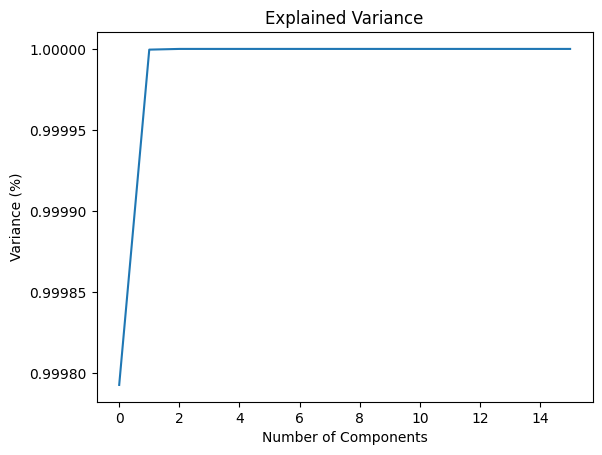

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Effectuer une PCA
pca = PCA().fit(features)

# Tracer la variance expliquée cumulée
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation
corr_matrix = features.corr()

corr_matrix

,open,volumeto,market_cap,progression daily,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty
open,1.000000,0.724425,0.999673,-0.010186,0.992889,0.997169,0.157425,-0.024460,-0.012519,0.859309,0.893863,0.991260,0.986485,-0.010248,0.077930,0.692039
volumeto,0.724425,1.000000,0.717525,-0.017553,0.717025,0.723973,0.181848,0.015977,0.271129,0.728472,0.804493,0.740401,0.685379,0.015622,0.046104,0.419655
market_cap,0.999673,0.717525,1.000000,-0.010996,0.993086,0.997101,0.152752,-0.026446,-0.012770,0.851525,0.888209,0.990640,0.987468,-0.013541,0.075038,0.703429
progression daily,-0.010186,-0.017553,-0.010996,1.000000,-0.025330,-0.023701,0.026697,0.159195,0.018530,0.000204,-0.016846,-0.023761,-0.027572,0.226594,0.108989,-0.022322
ema_26,0.992889,0.717025,0.993086,-0.025330,1.000000,0.998403,0.054120,-0.085833,-0.020268,0.838178,0.900118,0.996532,0.994642,-0.067880,-0.025736,0.700732
ema_12,0.997169,0.723973,0.997101,-0.023701,0.998403,1.000000,0.110442,-0.061301,-0.016846,0.849906,0.899730,0.996170,0.993245,-0.049990,0.010596,0.696223
macd,0.157425,0.181848,0.152752,0.026697,0.054120,0.110442,1.000000,0.426549,0.058818,0.276327,0.067248,0.075663,0.057203,0.310638,0.640094,-0.021995
rsi,-0.024460,0.015977,-0.026446,0.159195,-0.085833,-0.061301,0.426549,1.000000,0.161767,0.053081,-0.076028,-0.081514,-0.096534,0.741827,0.487110,-0.080912
relative_volume,-0.012519,0.271129,-0.012770,0.018530,-0.020268,-0.016846,0.058818,0.161767,1.000000,0.005173,-0.032592,-0.023419,-0.017760,0.086563,0.067285,-0.019540
obv,0.859309,0.728472,0.851525,0.000204,0.838178,0.849906,0.276327,0.053081,0.005173,1.000000,0.844573,0.852100,0.819689,0.055826,0.154347,0.502792


In [42]:
from keras import backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))

In [48]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import F1Score


# Préparation des données
X = features.values
y = target.values
y = target.values.astype(np.float32)


# Définition du modèle LSTM
model = keras.Sequential([
    layers.InputLayer(input_shape=(X.shape[1], 1)),  # X.shape[1] : nombre de features
    layers.LSTM(16, return_sequences=True),  # *** : nombre d'unités pour la première couche LSTM
    layers.LSTM(8),  # *** : nombre d'unités pour la deuxième couche LSTM
    layers.Dense(1, activation='sigmoid')
])

# Compilation du modèle avec la métrique F1
f1_metric = F1Score(threshold=0.5)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=30)  # *** : nombre de splits

for train_index, test_index in tscv.split(X):
    # 1. Séparation des données
    X_train_raw, X_test_raw = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 2. Normalisation des données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # 3. Reshape pour LSTM
    X_train = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_test = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    
    # Entraînement du modèle
    model.fit(X_train, y_train, epochs=10, batch_size=30)
    
    # Évaluation du modèle sur le sous-ensemble de test
    loss = model.evaluate(X_test, y_test)
    print(f"Loss for split: {loss}")

Epoch 1/10
5/5 [==============================] - 3s 11ms/step - loss: 0.6969 - accuracy: 0.4552 - f1_score: 0.4427
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6906 - accuracy: 0.4925 - f1_score: 0.4769
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6871 - accuracy: 0.5448 - f1_score: 0.5481
Epoch 4/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6819 - accuracy: 0.5597 - f1_score: 0.5693
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 0.6782 - accuracy: 0.5597 - f1_score: 0.5693
Epoch 6/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6754 - accuracy: 0.5597 - f1_score: 0.5693
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6728 - accuracy: 0.5597 - f1_score: 0.5693
Epoch 8/10
5/5 [==============================] - 0s 18ms/step - loss: 0.6717 - accuracy: 0.5672 - f1_score: 0.5797
Epoch 9/10
5/5 [==============================] - 0s 10ms/step - loss: 0.